# 1MG - HIEU DO DUC Data Analyst Recruitment Test

# Section 1: Data Exploration

## Loading required libraries

In [56]:
# Libraries are imported by chronological order of being used
import os
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from IPython.display import Image
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


## Loading datasets

In [57]:
# Function to load all dataset
def load_csv_files():
    csv_dataframes = {}
    current_directory = os.getcwd()
    for file in os.listdir(current_directory):
        if file.endswith(".csv"):
            filename = os.path.splitext(file)[0]  # Get filename without extension
            try:
                csv_dataframes[filename] = pd.read_csv(os.path.join(current_directory, file))
                print(f"Dataset '{filename.replace('olist_', '')}' has been loaded.")  # Print without 'olist_' prefix
            except Exception as e:
                print(f"Error loading dataset '{filename}': {e}")
    return csv_dataframes

# Load CSV
csv_dataframes = load_csv_files()

# Assign each dataset to be a global variable without the 'olist_' prefix 
for filename, dataframe in csv_dataframes.items():
    # Remove the 'olist_' prefix from filename
    new_filename = filename.replace('olist_', '')
    globals()[new_filename] = dataframe


Dataset 'customers_dataset' has been loaded.
Dataset 'geolocation_dataset' has been loaded.
Dataset 'orders_dataset' has been loaded.
Dataset 'order_items_dataset' has been loaded.
Dataset 'order_payments_dataset' has been loaded.
Dataset 'order_reviews_dataset' has been loaded.
Dataset 'products_dataset' has been loaded.
Dataset 'sellers_dataset' has been loaded.
Dataset 'product_category_name_translation' has been loaded.


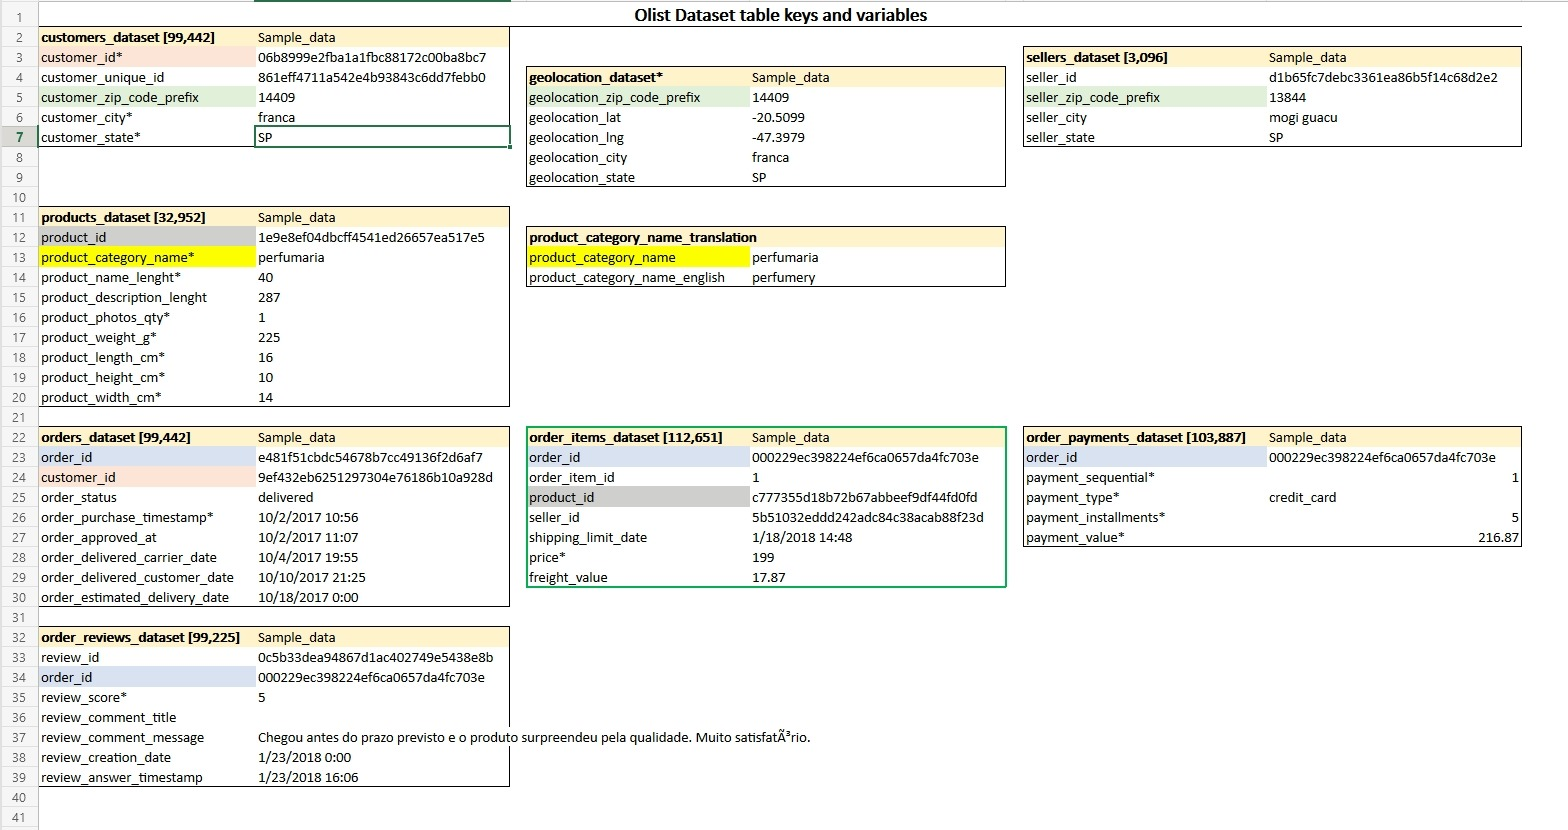

In [58]:
# Display the data-map
Image(filename='data-map.jpg')


This dataset encompasses details on 100,000 anonymized orders within the e-commerce domain. It delves into diverse aspects of orders, covering order status, product specifics, pricing, payment, and shipping performance. Furthermore, it incorporates customer-related metrics like location and reviews. Additionally, a geolocation dataset is included, linking Brazilian postal codes. 

Moving forward, we will initiate data processing to ensure the data's cleanliness.







## Data Pre-procerssing

#### Missing Value Imputation

In [59]:
# Iterate over each loaded dataset to check for missing value
for dataset_name, dataset_df in csv_dataframes.items():
    print(f"\nColumns with missing values in dataset '{dataset_name.replace('olist_', '')}':")
    missing_columns = dataset_df.columns[dataset_df.isnull().any()].tolist()
    if missing_columns:
        print(f"Missing values in columns: {', '.join(missing_columns)}")
    else:
        print("No missing values in any columns.")



Columns with missing values in dataset 'customers_dataset':
No missing values in any columns.

Columns with missing values in dataset 'geolocation_dataset':
No missing values in any columns.

Columns with missing values in dataset 'orders_dataset':
Missing values in columns: order_approved_at, order_delivered_carrier_date, order_delivered_customer_date

Columns with missing values in dataset 'order_items_dataset':
No missing values in any columns.

Columns with missing values in dataset 'order_payments_dataset':
No missing values in any columns.

Columns with missing values in dataset 'order_reviews_dataset':
Missing values in columns: review_comment_title, review_comment_message

Columns with missing values in dataset 'products_dataset':
Missing values in columns: product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm

Columns with missing values in dataset 'sellers_dataset':

As can be seen, only 3 tables have missing values. 

Among them, the missing value in order_reviews dataset can be considered as an expected behaviour, as someone can rate an order without having any comments/titles

Similar to product dataset, after a small exploration, the missing values has no effect on our analysis. Thus, we will not pursuit further with this table's missing values.

That left behind only orders dataset. The 3 columns with missing values found are: order_approved_at, carrier date and delivered customer date. From our gut feeling, we can safely say that these values are missing because an order was cancelled or interupted. Let's inviestigate our assumptions:

In [60]:
missing_values_per_status = orders_dataset.groupby('order_status').apply(lambda x: x.isnull().sum())
missing_values_per_status[['order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']]

,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_status,,,,
approved,0,2,2,0
canceled,141,550,619,0
created,5,5,5,0
delivered,14,2,8,0
invoiced,0,314,314,0
processing,0,301,301,0
shipped,0,0,1107,0
unavailable,0,609,609,0


In contrast to our previous assumptions, we found a couple of anomaly within our system. Specifically, there were 14 transactions marked as delivered without the customer's approval datetime, highlighting potential data quality issues that may lead to data completeness. Similarly, while the status of the order is shipped, around 1% of our total number of delivery did not report the exact delivered date. Frieght costs will be consiquently being more difficulte to be quantified.

<span style="color:red">One can argue that the number of missing values is too small (1%) compared to total number of transactions, it is suggested for us to report this number with logistic deparment and their data engineer to dictate the root cause behind the phenomenon and to re-evaluate and monitor the data collection procedure.</span>

From this analysis perspective, aforementioned missing values will not need to be cleaned, as it will not affect our analysis or we will simply remove it if needed.

As a next step, we are moving forward to EDA part of this analysis:



## Exploratory Data Analysis (EDA)

The idea of the EDA analysis is to deep dive into our data to draw actionable insights. Taking a look at our list of dataset, it can be seen that these datasets can be categorized to 5 different dimensions:
1. Product
2. Delivery
3. Payment
4. Geolocation
5. Order
6. Repeat Customer


We will go to each analysis individually as follow:

### 1. Product Analysis


In [61]:
# Left join products and product_category_name_translation DataFrames
products_with_translated_name = pd.merge(products_dataset, product_category_name_translation, 
                     left_on='product_category_name', right_on='product_category_name',
                     how='left')
products_with_translated_name.rename(columns={'product_category_name_english': 'product_name'}, inplace=True)

# Left join orders, order_items, products2, and order_reviews DataFrames
merged_data = pd.merge(orders_dataset, order_items_dataset, on='order_id', how='left')
merged_data = pd.merge(merged_data, products_with_translated_name, on='product_id', how='left')
merged_data = pd.merge(merged_data, order_reviews_dataset, on='order_id', how='left')

# Filter out rows where product_name is not null
merged_data = merged_data[merged_data['product_name'].notnull()]

# # Calculate delivery time and packing time
# merged_data['delivery_time'] = (pd.to_datetime(merged_data['order_delivered_customer_date']) - 
#                                 pd.to_datetime(merged_data['order_purchase_timestamp'])).dt.days


In [62]:
# Left join products and product_category_name_translation DataFrames
products_with_translated_name = pd.merge(products_dataset, product_category_name_translation, 
                     left_on='product_category_name', right_on='product_category_name',
                     how='left')
products_with_translated_name.rename(columns={'product_category_name_english': 'product_name'}, inplace=True)

# Left join orders, order_items, products2, and order_reviews DataFrames
merged_data = pd.merge(orders_dataset, order_items_dataset, on='order_id', how='left')
merged_data = pd.merge(merged_data, products_with_translated_name, on='product_id', how='left')
merged_data = pd.merge(merged_data, order_reviews_dataset, on='order_id', how='left')

# Filter out rows where product_name is not null
merged_data = merged_data[merged_data['product_name'].notnull()]

# Calculate delivery time and packing time
merged_data['delivery_time'] = (pd.to_datetime(merged_data['order_delivered_customer_date']) - 
                                pd.to_datetime(merged_data['order_purchase_timestamp'])).dt.days


After processing and merging some of out dataframes, we have had a unified dataframe with informations about Product that is ready for analysis. Next, we want to group some of Product Attributes such as Price and Freight, etc. However, we want to see the distributions of these attributes before grouping, specifically seeing if the distribution containing outliers or not:

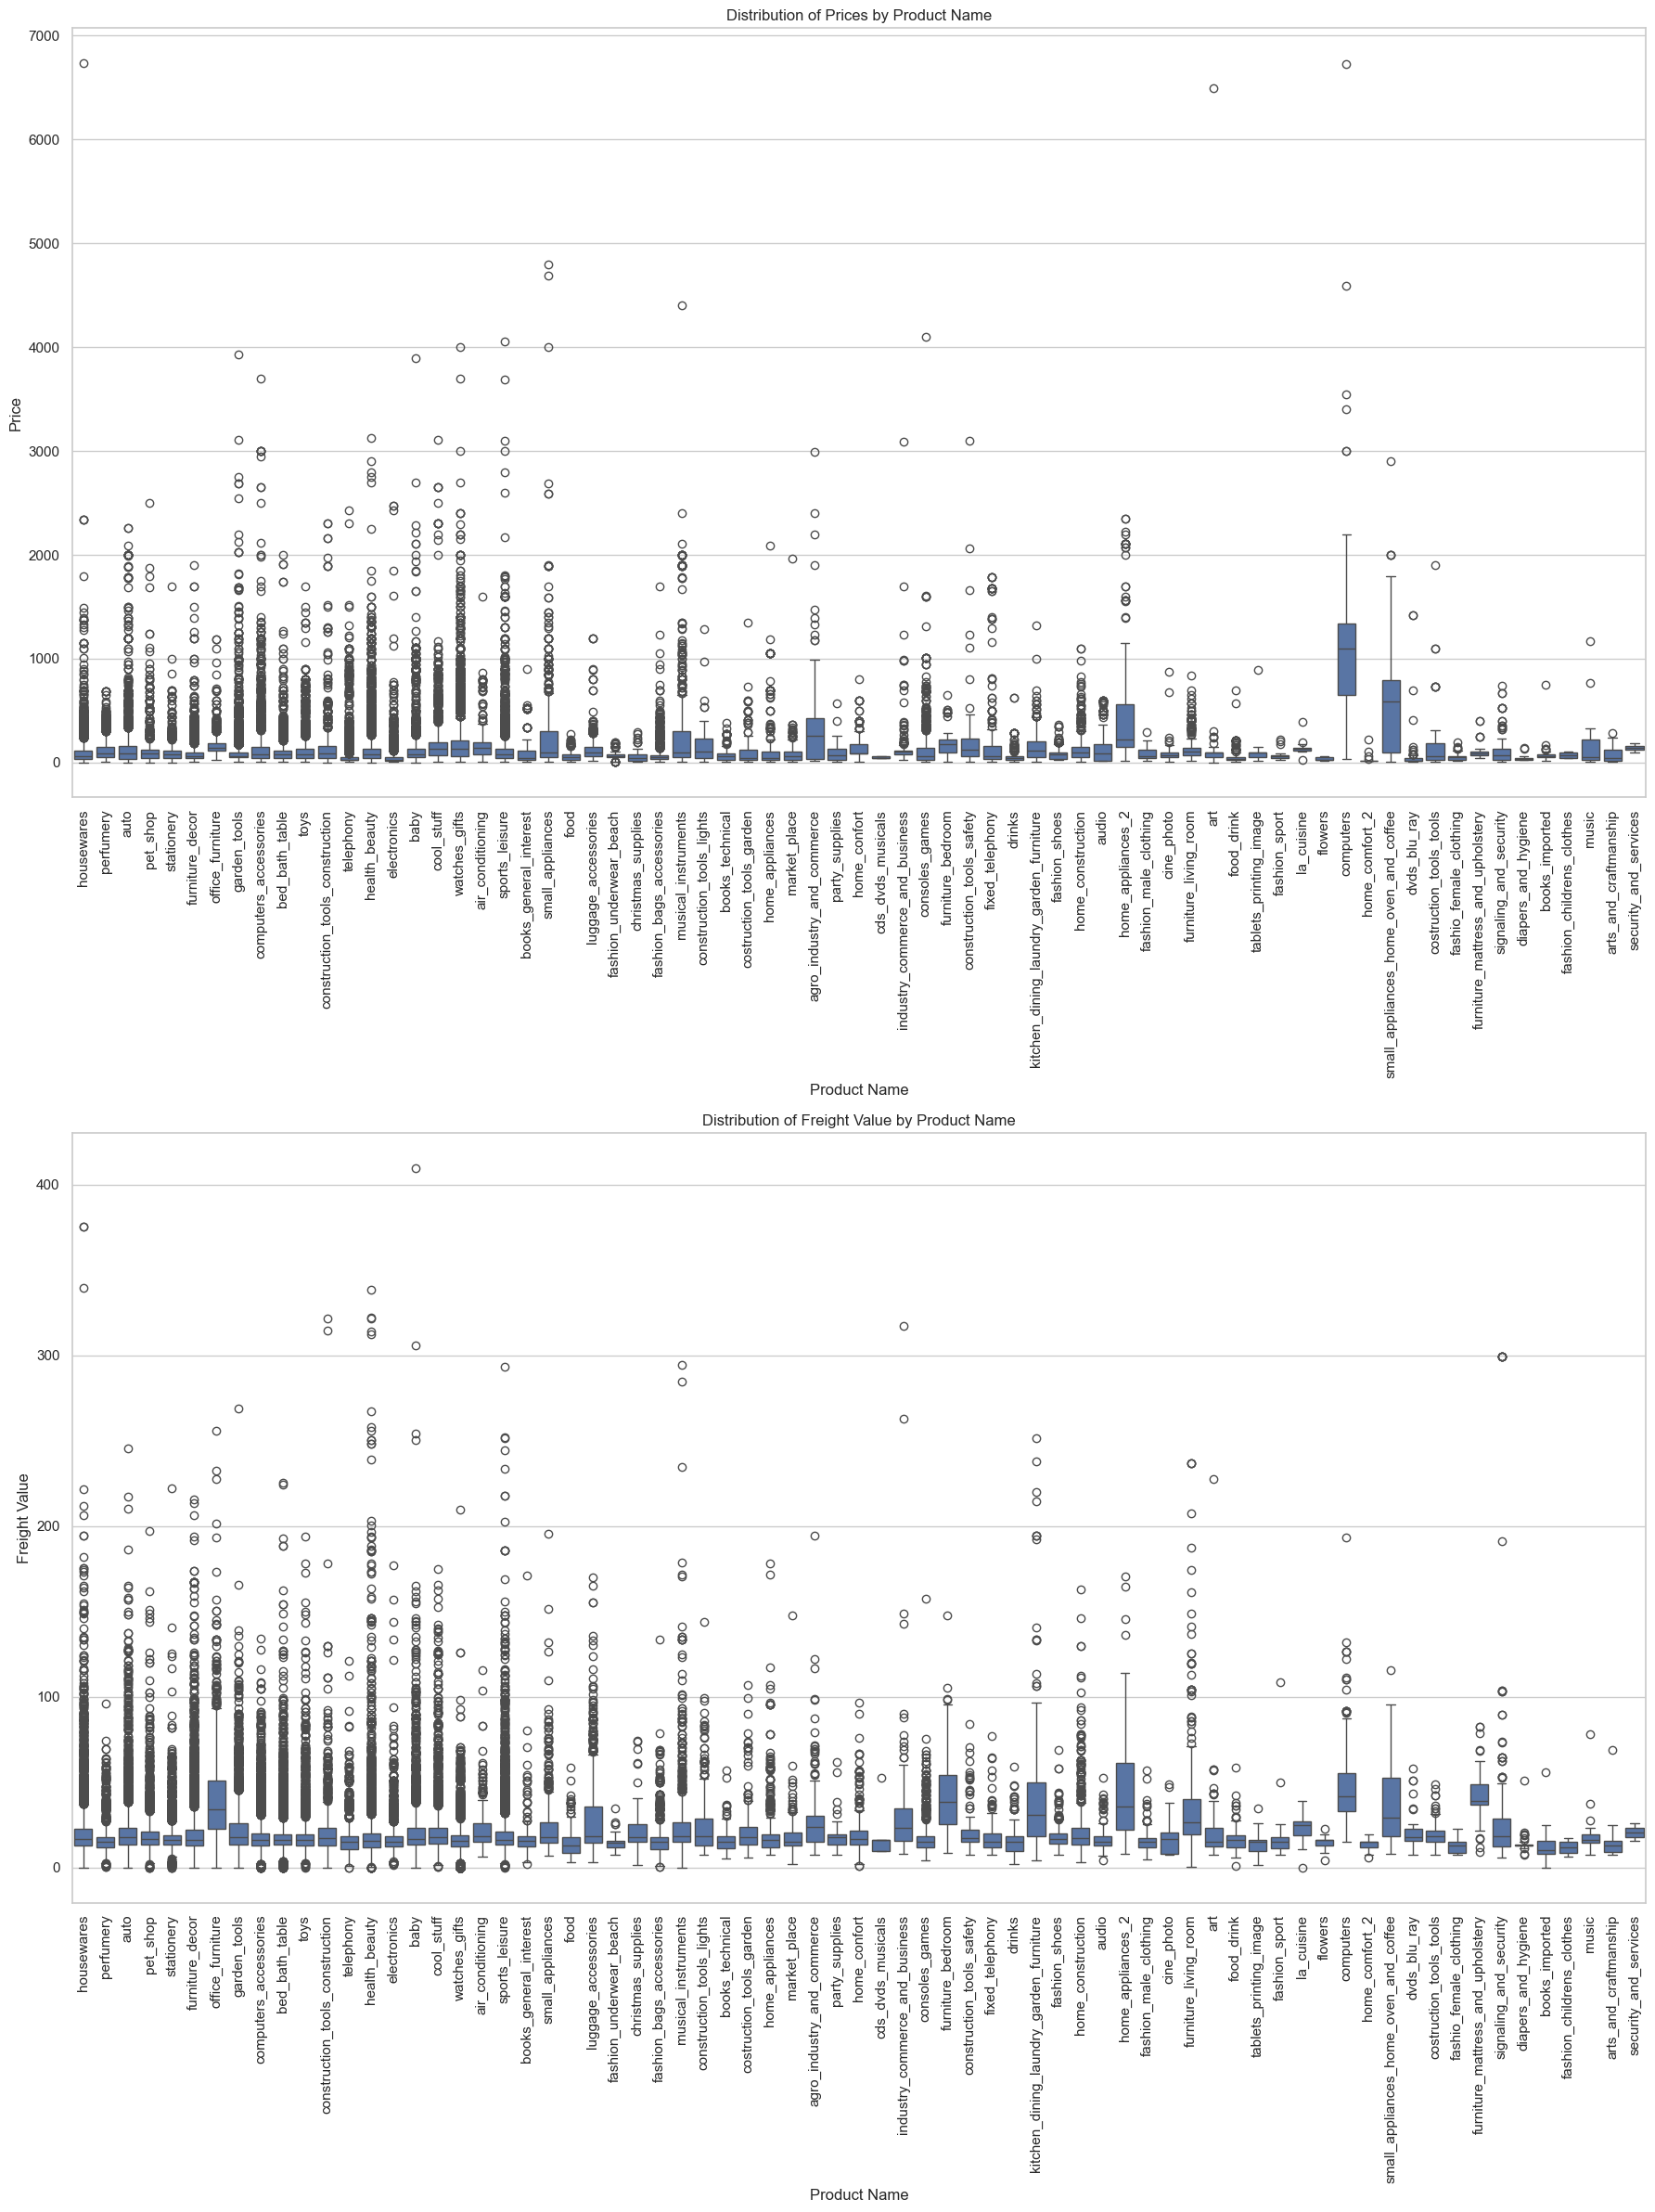

In [63]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(18, 24))

# Plot for price
sns.boxplot(x='product_name', y='price', data=merged_data, ax=axes[0])
axes[0].set_title('Distribution of Prices by Product Name')
axes[0].set_ylabel('Price')
axes[0].set_xlabel('Product Name')
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

# Plot for freight_value
sns.boxplot(x='product_name', y='freight_value', data=merged_data, ax=axes[1])
axes[1].set_title('Distribution of Freight Value by Product Name')
axes[1].set_ylabel('Freight Value')
axes[1].set_xlabel('Product Name')
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels


# Adjust layout
plt.tight_layout()
plt.show()


The analysis of our product's pricing, freight value, and delivery time reveals notable variations. Particularly in the case of **Art** category, while the median and interquartile range encompass a range typically below a few hundred Brazilian Real, an outlier stands out with a price nearing 6800 BRL *R$*. Utilizing an average or mean for comparison in this context would significantly distort our analysis due to the influence of such outliers. In fact, due to the presence of outliers, a comparison of prices between **Home_appliances_2** and **Agro_industry_and_commerce** using mean or median yields differing outcomes regarding which product boasts a higher average price (*223.90* - *258.65* versus *473.05* - *342.12*). Hence, to ensure a robust and representative assessment, the median will be employed as a more suitable measure for central tendency within this data analysis. Further considerations regarding data handling and outlier treatment may also be warranted to enhance the accuracy and reliability of our findings.

Consequently, we group Price, Freight_value, Review_score, and Number of Purchase as follow:


In [64]:
# Group by product_name and calculate averages
product_finaldf = merged_data.groupby('product_name').agg({'price': 'median', 
                                                  'freight_value': 'median', 
                                                  'review_score': 'mean',
                                                  'order_id': 'size'}).reset_index()

# Rename columns
product_finaldf.rename(columns={'price': 'avg_price',
                       'freight_value': 'avg_freight',
                       'review_score': 'avg_review_score',
                       'order_id': 'no_of_orders'
                       }, inplace=True)

# Sort by product_cnt in descending order and limit to top 100
product_finaldf = product_finaldf.sort_values(by='avg_price', ascending=False).head(100)
product_finaldf.head(5)


,product_name,avg_price,avg_freight,avg_review_score,no_of_orders
14,computers,1100.00,41.55,4.142857,203
64,small_appliances_home_oven_and_coffee,587.00,28.98,4.302632,76
0,agro_industry_and_commerce,258.65,23.68,4.000000,212
45,home_appliances_2,223.90,35.97,4.132780,241
38,furniture_bedroom,179.00,38.69,4.118182,110


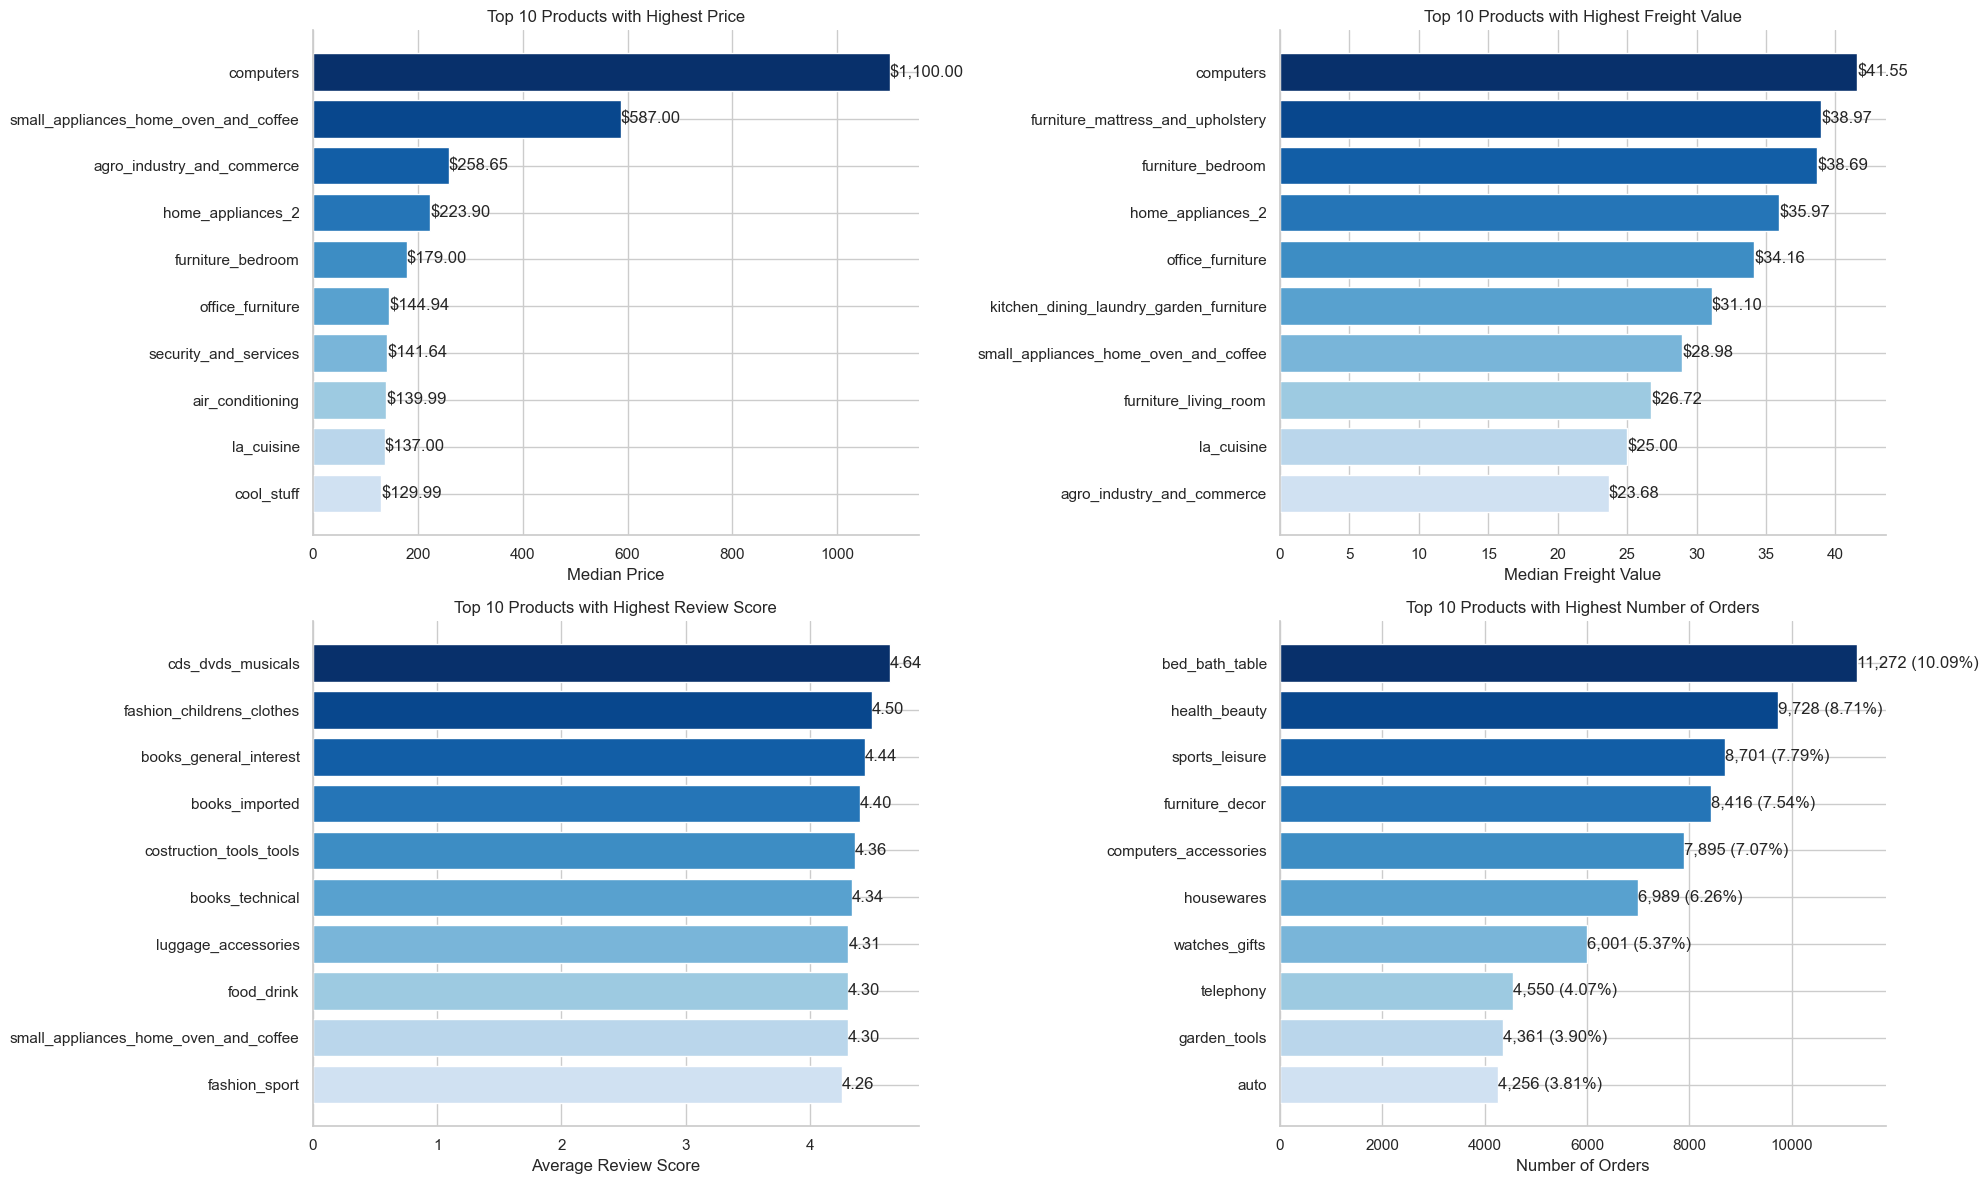

In [65]:
# Define color gradient
colors = plt.cm.Blues(np.linspace(0.2, 1, 10))

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# Top 10 products with highest price
top_10_price = product_finaldf.nlargest(10, 'avg_price')
top_10_price = top_10_price[::-1]  # Reversing the order for plotting
bars = axs[0, 0].barh(top_10_price['product_name'], top_10_price['avg_price'], color=colors)
axs[0, 0].set_xlabel('Median Price')
axs[0, 0].set_title('Top 10 Products with Highest Price')
for bar, value in zip(bars, top_10_price['avg_price']):
    axs[0, 0].text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'${value:,.2f}', va='center')

# Top 10 products with highest freight value
top_10_freight = product_finaldf.nlargest(10, 'avg_freight')
top_10_freight = top_10_freight[::-1]  # Reversing the order for plotting
bars = axs[0, 1].barh(top_10_freight['product_name'], top_10_freight['avg_freight'], color=colors)
axs[0, 1].set_xlabel('Median Freight Value')
axs[0, 1].set_title('Top 10 Products with Highest Freight Value')
for bar, value in zip(bars, top_10_freight['avg_freight']):
    axs[0, 1].text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'${value:,.2f}', va='center')

# Top 10 products with highest review score
top_10_review_score = product_finaldf.nlargest(10, 'avg_review_score')
top_10_review_score = top_10_review_score[::-1]  # Reversing the order for plotting
bars = axs[1, 0].barh(top_10_review_score['product_name'], top_10_review_score['avg_review_score'], color=colors)
axs[1, 0].set_xlabel('Average Review Score')
axs[1, 0].set_title('Top 10 Products with Highest Review Score')
for bar, value in zip(bars, top_10_review_score['avg_review_score']):
    axs[1, 0].text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'{value:.2f}', va='center')

# Top 10 products with highest number of purchases
top_10_purchases = product_finaldf.nlargest(10, 'no_of_orders')
top_10_purchases = top_10_purchases[::-1]  # Reversing the order for plotting
bars = axs[1, 1].barh(top_10_purchases['product_name'], top_10_purchases['no_of_orders'], color=colors)
axs[1, 1].set_xlabel('Number of Orders')
axs[1, 1].set_title('Top 10 Products with Highest Number of Orders')
for bar, value in zip(bars, top_10_purchases['no_of_orders']):
    axs[1, 1].text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'{value:,.0f} ({value / product_finaldf["no_of_orders"].sum() * 100:.2f}%)', 
             va='center')

# Remove spines
for ax in axs.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

# Add boundaries between plots
axs[0, 0].spines['bottom'].set_visible(True)
axs[0, 1].spines['bottom'].set_visible(True)
axs[0, 1].spines['left'].set_visible(True)
axs[1, 1].spines['left'].set_visible(True)

plt.tight_layout()
plt.show()


<font color="green">In reviewing our product lineup, we've uncovered some significant findings. 

Computers stand out as both the most expensive and having the highest freight value. Moreover, the notably higher freight value for computers compared to heavier items like mattresses and furniture indicating potential challenges in production and logistics that require efficient management for profitability and customer satisfaction. Possible reasons for this difference may include inefficient shipping methods, long shipping distances due to manufacturing location, or other suboptimal logistics strategies. Addressing these challenges could involve reassessing shipping methods, optimizing supply chain logistics, or implementing targeted marketing campaigns to encourage computer purchases despite higher freight costs. By addressing these potential weak points, we can improve the competitiveness of our computer offerings and enhance overall customer satisfaction and sales performance.

On a positive note, small appliances such as home ovens and coffee makers are performing exceptionally well. Despite their costs, these products are consumer favorites, highlighting their value and quality. We should aim to capitalize on this success by refining pricing strategies and logistics to drive growth and strengthen our position in the small appliance market.

Besides, our top-selling products span a wide range of consumer interests, underscoring the importance of catering to diverse preferences for long-term market relevance.</font>

Zooming out, it can be observed that 7 out of 10 most expensive product also appear in top 10 product with highest freight value. As correlations between these product attributes is suspected, a correlation analysis will be adopted next:

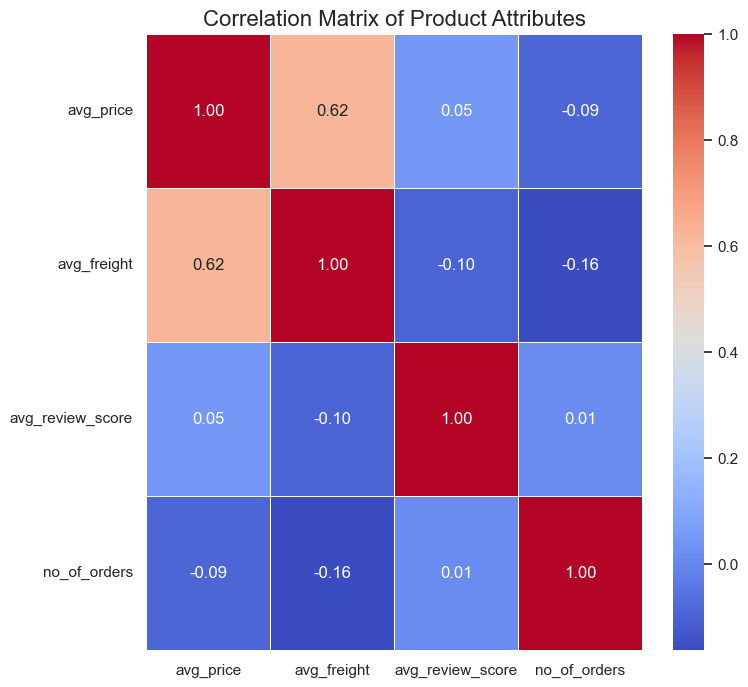

In [66]:
correlation_matrix = product_finaldf[['avg_price', 'avg_freight', 'avg_review_score', 'no_of_orders']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Add title
plt.title('Correlation Matrix of Product Attributes', fontsize=16)

# Rotate y-axis labels for better readability
plt.yticks(rotation=0)

# Show plot
plt.show()


In [67]:
# from scipy import stats

# df = product_finaldf.copy()
# # Calculate z-score for 'avg_price'
# z_scores = np.abs(stats.zscore(df['avg_price']))

# # Define threshold for outliers (e.g., z-score > 3)
# threshold = 3

# # Filter out rows with outliers
# df_filtered = df[z_scores <= threshold]

# # Scatter plot
# plt.figure(figsize=(8, 6))
# plt.scatter(df_filtered['no_of_orders'], df_filtered['avg_price'], color='blue', label='Data Points')

# # Line of best fit
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_filtered['no_of_orders'], df_filtered['avg_price'])
# line = slope * df_filtered['no_of_orders'] + intercept
# plt.plot(df_filtered['no_of_orders'], line, color='red', label='Trend Line')

# # Add labels and title
# plt.xlabel('Number of Orders')
# plt.ylabel('Average Price')
# plt.title('Relationship between Number of Orders and Average Price (Outliers Removed)')

# # Add legend
# plt.legend()

# # Show plot
# plt.grid(True)
# plt.show()




Positive Correlations:
- There's a strong positive correlation between average price and average freight, indicating that higher-priced products tend to have higher freight costs. This finding confirms our assumptions above of correlation between these two product attributes.
- There's a moderate positive correlation between average freight and delivery time, suggesting that as freight costs increase, delivery times tend to increase as well.

Negative Correlations:
- There's a weak negative correlation between average price and the number of orders, indicating that higher-priced products may receive fewer orders.
- There's a weak negative correlation between average freight and the number of orders, suggesting that higher freight costs may lead to slightly fewer orders.

Other Insights:
- The correlation between average price and average review score, as well as between average freight and average review score, is very weak, indicating that price or freight cost doesn't significantly impact the review scores of products.
- There's almost no correlation between average review score and the number of orders, suggesting that the number of orders a product receives is not strongly influenced by its review score.
- Similarly, there's almost no correlation between delivery time and the number of orders.

Summing up, we finalize the Product Analysis with below key takeaway:




<font color="green">Product Analysis Takeaway and Key Performance Indicator
Key Findings:

Correlation Between Product Price and Freight Value:

- As expected, there is a strong correlation between product price and their freight value. Higher freight costs can contribute to higher overall product costs, particularly if those costs are passed on to consumers. For instance, the unexpectedly high freight value for computers may pose challenges in reaching customers at competitive prices.
Impact of Price and Freight Cost on Review Scores:

- Interestingly, our analysis reveals that neither price nor freight cost significantly impacts the review scores of products. This suggests that while freight costs are an essential consideration for businesses, they may not directly influence customer satisfaction as reflected in review scores. Further investigation into other factors affecting customer satisfaction could provide valuable insights.
Variety of Popular Product Types:

- We observe a diverse range of product types being popular among customers, which is a positive indicator of market demand. However, optimizing our logistics procedures to lower freight and total product costs for high-value items can further enhance profitability.

Key Performance Indicator:
The key action to take away from these findings is to revise our logistics procedures to lower Freight Cost as a Percentage of Product Cost. For example, negotiating favorable terms with carriers, optimizing shipping routes, or implementing efficient packaging solutions can help lower this percentage, thereby improving profitability and potentially increasing Gross Merchandise Value (GMV).
</font>

---------

### 2. Delivery Analysis

In [68]:
# Define the initial DataFrame 'delivery2'
delivery = merged_data.copy()
delivery=delivery[delivery['order_status']=='delivered']
# Convert date columns to datetime type
delivery['order_delivered_customer_date'] = pd.to_datetime(delivery['order_delivered_customer_date'])
delivery['order_estimated_delivery_date'] = pd.to_datetime(delivery['order_estimated_delivery_date'])

# Check the cleanliness of data
rows_with_null_values = delivery[delivery[['order_delivered_customer_date', 'order_estimated_delivery_date']].isnull().any(axis=1)]

# Print rows with null values
print("Number of Delivered Transaction without delivery details: {}".format(rows_with_null_values.shape[0]))
print("Unexpectedly, there were {} records marked with delivered but missing one of the information about delivery date. Thus we will remove them record for the sake of data integrity". format(rows_with_null_values.shape[0]))

# Dropping rows with status delivered and null delivery time information
# Create a new DataFrame without rows containing null, NaT, or NaN values from specified columns
delivery = delivery.dropna(subset=['order_delivered_customer_date', 'order_estimated_delivery_date'])


Number of Delivered Transaction without delivery details: 8
Unexpectedly, there were 8 records marked with delivered but missing one of the information about delivery date. Thus we will remove them record for the sake of data integrity


In [69]:

delivery['hour_of_day'] = pd.to_datetime(delivery['order_delivered_customer_date']).dt.hour
delivery['delivery_status_time'] = delivery.apply(lambda row: 'late_delivery' if row['order_delivered_customer_date'] > row['order_estimated_delivery_date'] else 'on_time_delivery', axis=1)
delivery=delivery[['order_id','product_name','delivery_time','hour_of_day','delivery_status_time','order_delivered_customer_date','order_estimated_delivery_date']]
delivery.drop_duplicates(inplace=True)


# Calculate total deliveries by delivery status
delivery_status_counts = delivery.groupby('delivery_status_time').size().reset_index(name='cnt')

# SAnalyze distribution of deliveries by month of the year
delivery['month_of_year'] = delivery['order_delivered_customer_date'].dt.strftime('%B-%Y')
delivery_month_counts = delivery.groupby('month_of_year').agg(
    cnt=('order_id', 'count'),
    on_time_cnt=('delivery_status_time', lambda x: (x == 'on_time_delivery').sum()),
    late_cnt=('delivery_status_time', lambda x: (x == 'late_delivery').sum())
).reset_index()


# Analyze distribution of deliveries by hour of the day
delivery_time_counts = delivery.groupby('hour_of_day').agg(
    cnt=('order_id', 'count'),
    on_time_cnt=('delivery_status_time', lambda x: (x == 'on_time_delivery').sum()),
    late_cnt=('delivery_status_time', lambda x: (x == 'late_delivery').sum())
).reset_index()


C:\Users\hieu\AppData\Local\Temp\ipykernel_19956\1501157836.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=delivery_time_counts, x='hour_of_day', y='cnt', ax=ax2, palette=palette)


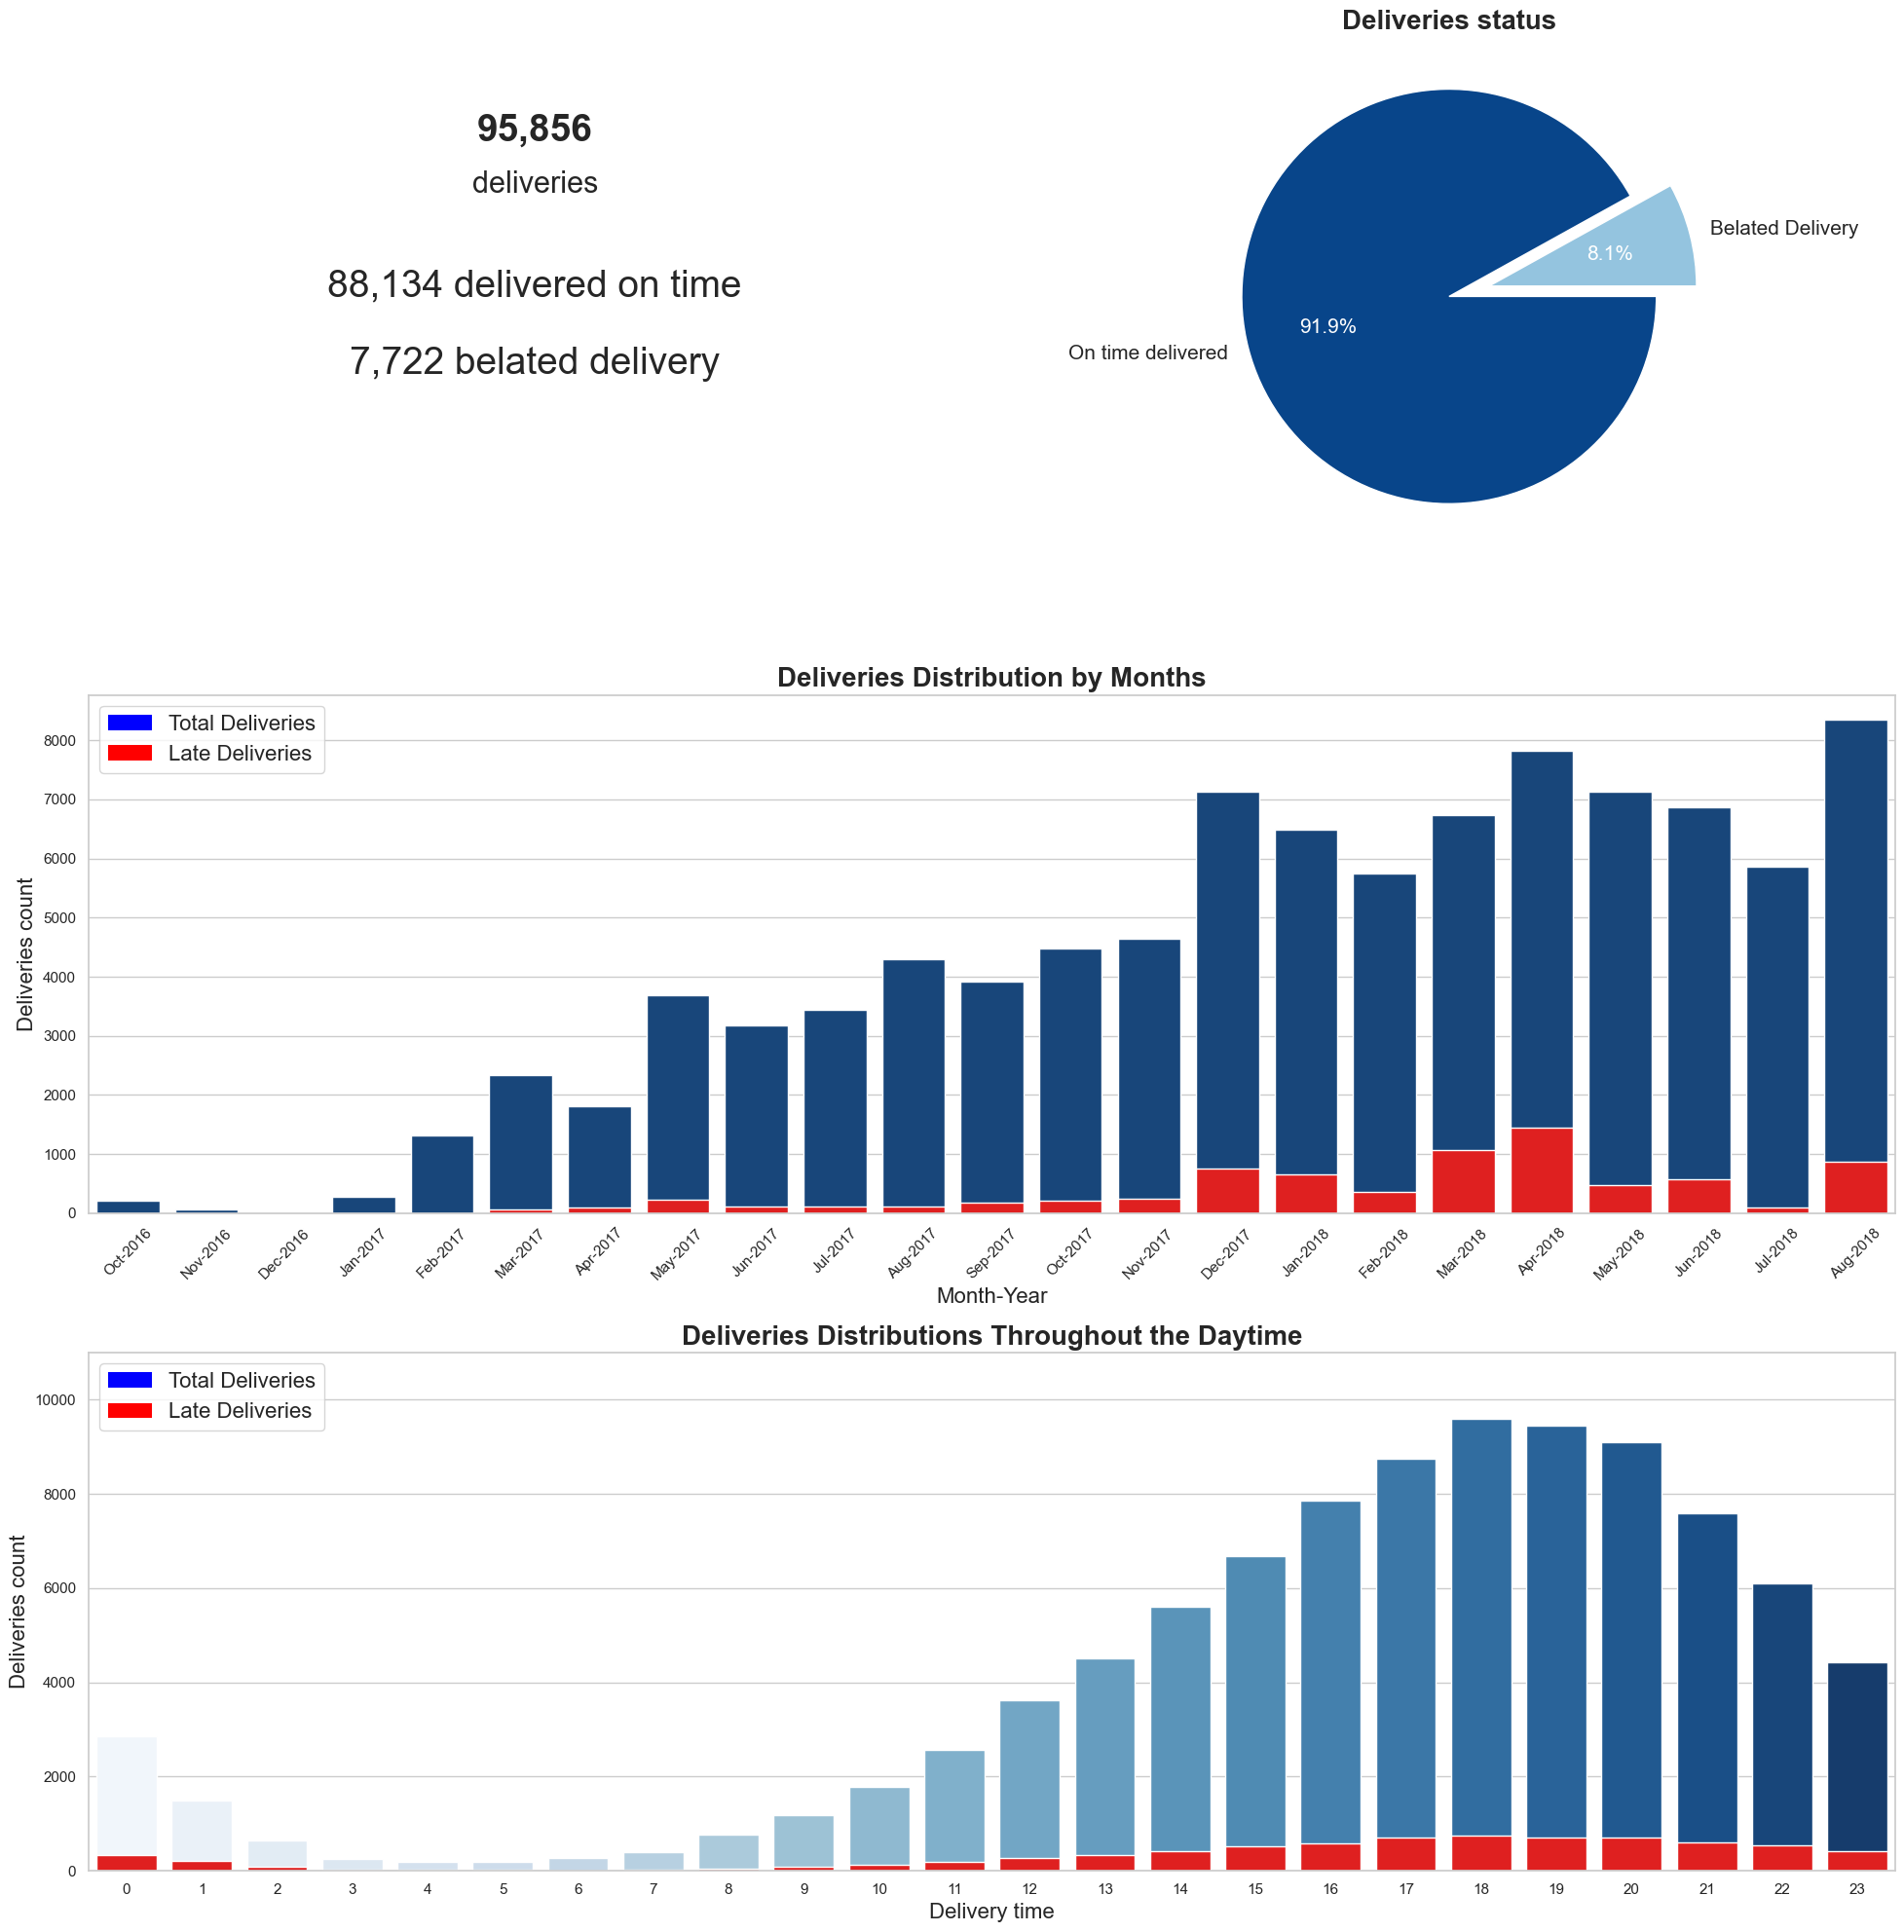

In [70]:
# Create color palettes
GnBu_palette = sns.color_palette('Blues_d')
Spectral_palette = sns.color_palette('Spectral')

# Define the number of unique hours of the day

n_hours = len(delivery_time_counts['hour_of_day'].unique())

# Generate a custom color palette with the desired effect
palette = sns.color_palette("Blues", n_hours)

# Set up the figure and subplots
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1])

# Plot 1: Text panel for total deliveries
ax_text = fig.add_subplot(gs[0, 0], frameon=False)
ax_text.text(0.5, 0.8, f'{delivery_status_counts["cnt"].sum():,.0f}', fontweight='bold', fontsize=28, ha='center')
ax_text.text(0.5, 0.7, 'deliveries', fontsize=22, ha='center')
ax_text.text(0.5, 0.5, f'{delivery_time_counts["on_time_cnt"].sum():,.0f} delivered on time', fontsize=28, ha='center')
ax_text.text(0.5, 0.35, f'{delivery_time_counts["late_cnt"].sum():,.0f} belated delivery', fontsize=28, ha='center')
# Remove axis
ax_text.axis('off')

# Plot 2: Pie chart for order submission status
explode = (0.2, 0.0)
ax1 = fig.add_subplot(gs[0, 1])
wedges, texts, autotexts = ax1.pie(x=delivery_status_counts['cnt'], labels=['Belated Delivery', 'On time delivered'], explode=explode, colors=[palette[9],palette[-2]], autopct='%.1f%%', textprops={'fontsize': 15})
ax1.set_title('Deliveries status', fontsize=20, fontweight='bold')
for text, color in zip(autotexts, colors):
    text.set_color('white')
# Plot 3: Bar plot for delivery time

ax2 = fig.add_subplot(gs[2,: ])
sns.barplot(data=delivery_time_counts, x='hour_of_day', y='cnt', ax=ax2, palette=palette)
sns.barplot(data=delivery_time_counts, x='hour_of_day', y='late_cnt', ax=ax2, color='red')
ax2.set_xlabel('Delivery time', fontsize=16)
ax2.set_ylabel('Deliveries count', fontsize=16)
ax2.set_title('Deliveries Distributions Throughout the Daytime', fontsize=20, fontweight='bold')
ax2.set_ylim(0, 11000)

# Plot 4: Bar plot for deliveries by month of year
darkest_color = palette[-2]

# Plot 4: Bar plot for deliveries by month of year
# Convert month_of_year to datetime objects
delivery_month_counts['month_of_year'] = pd.to_datetime(delivery_month_counts['month_of_year'], format='%B-%Y')

# We see data is incomplete since Sep 2018, for reporting purpose, we will have a rough cut over here
delivery_month_counts = delivery_month_counts[delivery_month_counts['month_of_year'] < '2018-09-01']

# Sort the DataFrame by month_of_year
delivery_month_counts_sorted = delivery_month_counts.sort_values(by='month_of_year')

# Convert back to "Month-Year" format
delivery_month_counts_sorted['month_of_year'] = delivery_month_counts_sorted['month_of_year'].dt.strftime('%b-%Y')

ax3 = fig.add_subplot(gs[1, :])
sns.barplot(data=delivery_month_counts_sorted, x='month_of_year', y='cnt', ax=ax3, color=darkest_color)
sns.barplot(data=delivery_month_counts_sorted, x='month_of_year', y='late_cnt', ax=ax3, color='red')
ax3.set_xlabel('Month-Year', fontsize=16)
ax3.set_ylabel('Deliveries count', fontsize=16)
ax3.set_title('Deliveries Distribution by Months', fontsize=20, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)

# Custom legend
total_deliveries_patch = plt.Rectangle((0,0),1,1,fc='blue', edgecolor = 'none')
late_deliveries_patch = plt.Rectangle((0,0),1,1,fc='red', edgecolor = 'none')
ax3.legend([total_deliveries_patch, late_deliveries_patch], ['Total Deliveries', 'Late Deliveries'], loc='upper left', fontsize=16)



# Custom legend
total_deliveries_patch = plt.Rectangle((0,0),1,1,fc='blue', edgecolor = 'none')
late_deliveries_patch = plt.Rectangle((0,0),1,1,fc='red', edgecolor = 'none')
ax2.legend([total_deliveries_patch, late_deliveries_patch], ['Total Deliveries', 'Late Deliveries'], loc='upper left', fontsize=16)


plt.tight_layout()
plt.show()


<font color="green">In the period from October 2016 to September 2018, 95,856 deliveries were aaccomplished. Of these, the on-time delivery rate is 91.9% (88,134 orders), while 8.1% of orders (7,722 orders) experienced delays.

Analysis shows a consistent upward trend in total deliveries, particularly during peak demand periods such as December 2017 to January 2018 (Chrismas), April 2018 (End of Semester), and August (back-to-school season). However, these periods also saw a higher incidence of late deliveries.

Further examination of order submission times revealed a gradual increase from sunrise to a peak at 18:00, followed by a decline.

In summary, while on-time delivery performance is commendable, there are opportunities for improvement, especially during peak demand periods. Addressing these challenges will bolster customer satisfaction and company's market position.</font>

-----

### 3. Payment

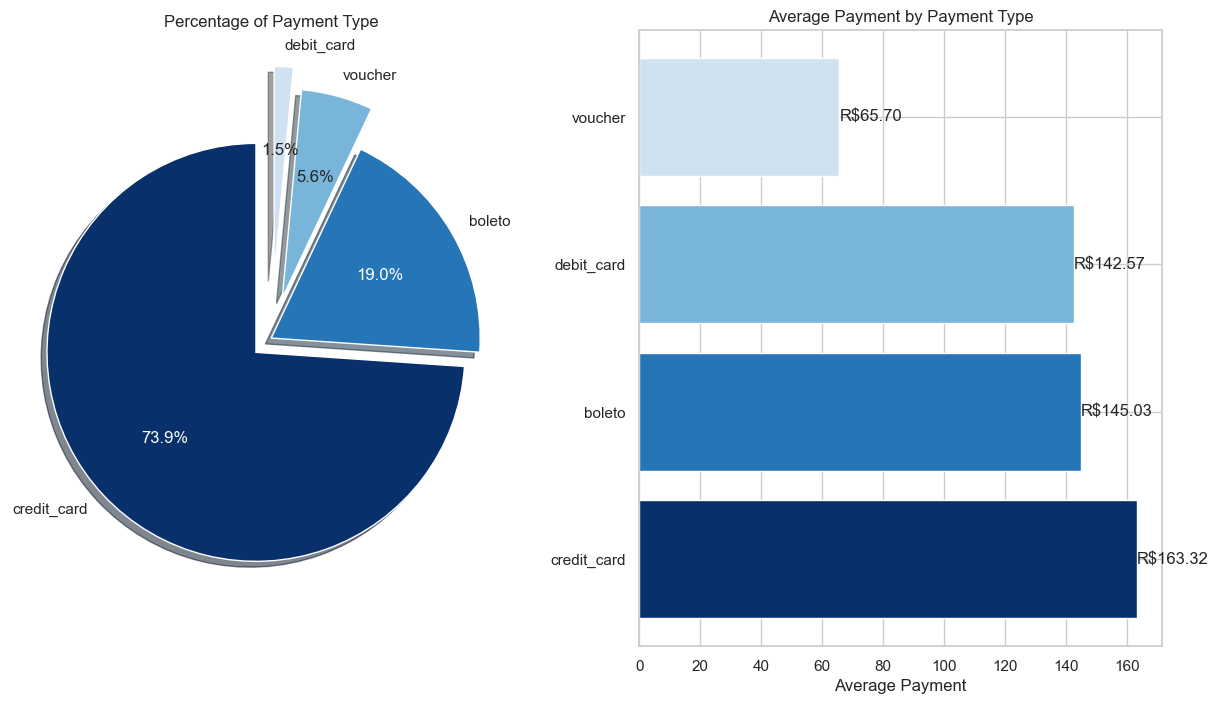

In [71]:
# Filter out rows where payment_type is not 'not_defined'
payment = order_payments_dataset[order_payments_dataset['payment_type'] != 'not_defined']

# Group by payment_type, count occurrences, and calculate average payment value
payment = payment.groupby('payment_type').agg(cnt=('payment_type', 'size'),
                                                      avg_payment=('payment_value', 'mean'))

# Sort the result by cnt in descending order
payment = payment.sort_values(by='cnt', ascending=False).reset_index()

# Data from your payment DataFrame
payment_type = payment['payment_type'].tolist()
num_of_payment = payment['cnt'].tolist()

avg_payment = payment['avg_payment'].tolist()

# Sorting payment types and their average payments
sorted_indices = np.argsort(avg_payment)[::-1]
sorted_payment_type = [payment_type[i] for i in sorted_indices]
sorted_avg_payment = [avg_payment[i] for i in sorted_indices]

# Creating color gradients
colors = plt.cm.Blues(np.linspace(0.2, 1, len(payment_type)))[::-1]

# Creating the pie chart
fig, axs = plt.subplots(1, 2, figsize=(12, 7))

# Pie chart
explode = (0.1, 0.0, 0.2, 0.3)
wedges, texts, autotexts = axs[0].pie(num_of_payment, autopct='%0.1f%%', explode=explode, labels=payment_type, shadow=True, colors=colors, startangle=90)
axs[0].set_title('Percentage of Payment Type', y=1.08)
for text, color in zip(autotexts, colors):
    if np.mean(color[:3]) < 0.5:  # Check if color is dark
        text.set_color('white')
# Bar chart
bar_plot = axs[1].barh(sorted_payment_type, sorted_avg_payment, color=colors)
axs[1].set_xlabel('Average Payment')
axs[1].set_title('Average Payment by Payment Type')
for bar, value in zip(bar_plot, sorted_avg_payment):
    axs[1].text(value, bar.get_y() + bar.get_height()/2, f'R${value:.2f}', va='center')  # 'R$' represents the symbol for Brazilian Real

# Reduce size of bar chart by 40%
box = axs[1].get_position()
axs[1].set_position([box.x0, box.y0, box.width * 0.6, box.height * 0.6])



plt.tight_layout()
plt.show()


<font color="green">The analysis indicates that credit cards dominate payments, comprising 73.9% of transactions, with boleto as the second, scores way lower with only 19%. On the other hand, average credit card payments amount to 163.3 R$, surpassing boleto's 145.0 R$. This underscores customer preference for credit cards and their inclination towards higher-value transactions compared to other payment method. Interestingly, boleto and debit card transaction values are comparable, suggesting factors beyond product price influence payment choice.

In conclusion: given the dominance of credit cards and their higher transaction values, consider initiatives to further incentivize credit card usage. Additionall, the company can also explore the factors driving boleto and debit card transactions to optimize payment methods and enhance customer experience.</font>







---

### 4. Geospatial Analysis


In [72]:
unique_geolocations = geolocation_dataset.drop_duplicates(subset = ['geolocation_zip_code_prefix'])
customers_geolocation = customers_dataset.merge(
    unique_geolocations,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
)
sellers_geolocation = sellers_dataset.merge(
    unique_geolocations,
    left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
)

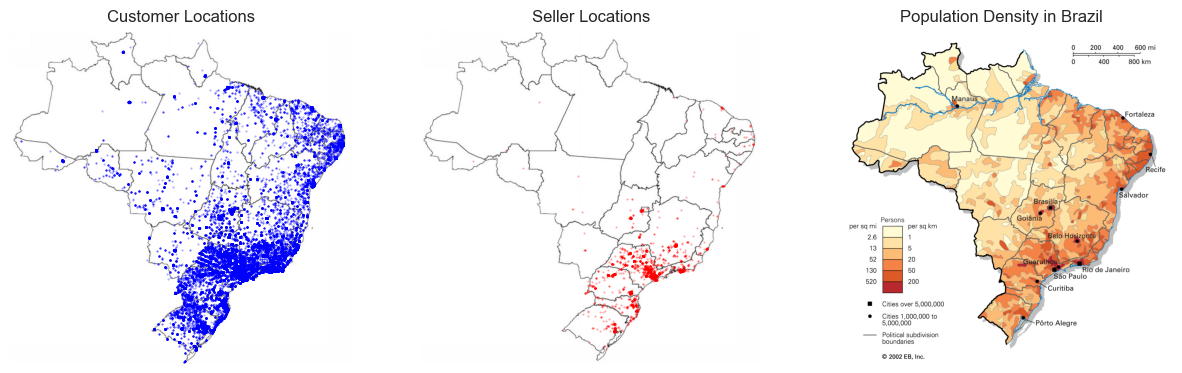

In [73]:
brazil = mpimg.imread(urllib.request.urlopen('https://i.pinimg.com/originals/3a/0c/e1/3a0ce18b3c842748c255bc0aa445ad41.jpg'),'jpg')
brazil_pop = mpimg.imread(urllib.request.urlopen('https://i.pinimg.com/originals/49/6a/9e/496a9eb46b42ea18ec4cc9922ba1cec7.gif'),'gif')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))

customers_geolocation.plot(
    kind="scatter",
    x="geolocation_lng",
    y="geolocation_lat",
    ax=ax1,
    alpha=0.3,
    s=0.3,
    c='blue'
)
ax1.imshow(brazil, extent=[-73.98283055, -33.8, -33.75116944, 5.4])
ax1.axis('off')
ax1.set_title('Customer Locations')

sellers_geolocation.plot(
    kind="scatter",
    x="geolocation_lng",
    y="geolocation_lat",
    ax=ax2,
    alpha=0.3,
    s=0.3,
    c='red'
)
ax2.imshow(brazil, extent=[-73.98283055, -33.8, -33.75116944, 5.4])
ax2.axis('off')
ax2.set_title('Seller Locations')

ax3.imshow(brazil_pop)
ax3.axis('off')
ax3.set_title('Population Density in Brazil')

plt.show()


<font color="green">Based on a basic geospatial analysis, it's evident that there's an imbalance in the distribution of customers and sellers. While both groups are predominantly clustered in major cities of southeastern Brazil like Curitiba, Sao Paulo, and notably Rio De Janeiro, sellers are primarily concentrated in this area, whereas customers extend to eastern regions such as Salvador and Recife. This indicates potentially high freight costs for customers due to the scarcity of sellers in their vicinity. To address this issue, we should forge partnerships with more sellers in the east and northeast, particularly in key urban centers. Concurrently, developing marketing strategies to penetrate the western region would be advantageous. By expanding our seller network and strategically targeting new markets, we can mitigate shipping expenses and enhance accessibility for customers across Brazil.</font>




### 5. Order Analysis

------

In [74]:
# Load and process order dataset
customer_orders = orders_dataset.copy()
customer_orders['year'] = pd.to_datetime(customer_orders['order_purchase_timestamp']).dt.year
customer_orders['month'] = pd.to_datetime(customer_orders['order_purchase_timestamp']).dt.month
customer_orders = customer_orders[(customer_orders['year'] < 2018) | ((customer_orders['year'] == 2018) & (customer_orders['month'] < 9))]

customer_order_items = order_items_dataset.merge(orders_dataset, on='order_id')
customer_order_items['gmv'] = customer_order_items['price'] + customer_order_items['freight_value']
customer_order_items['year'] = pd.to_datetime(customer_order_items['order_purchase_timestamp']).dt.year
customer_order_items['month'] = pd.to_datetime(customer_order_items['order_purchase_timestamp']).dt.month
customer_order_items = customer_order_items[(customer_order_items['year'] < 2018) | ((customer_order_items['year'] == 2018) & (customer_order_items['month'] < 9))]

# Define a function to convert month number to month name
def month_year_format(month, year):
    month_name = pd.to_datetime(int(month), format='%m').strftime('%B')
    return f"{month_name}-{year}"

# Group by year and month, and perform aggregation
order_distribution = customer_orders.groupby(['year', 'month']).size().reset_index(name='cnt')
nov_2016 = pd.DataFrame({'year': [2016], 'month': [11], 'cnt': [0]})
order_distribution = pd.concat([order_distribution, nov_2016], ignore_index=True)
order_distribution['Month_Year'] = order_distribution.apply(lambda row: month_year_format(row['month'], row['year']), axis=1)
order_distribution = order_distribution.sort_values(by=['year', 'month']).reset_index(drop=True)

gmv_distribution = customer_order_items.groupby(['year', 'month']).agg({'gmv': 'sum'}).reset_index()
# Adding November 2016 with GMV as 0
nov_2016 = pd.DataFrame({'year': [2016], 'month': [11], 'gmv': [0]})
gmv_distribution = pd.concat([gmv_distribution, nov_2016], ignore_index=True)
gmv_distribution['Month_Year']= gmv_distribution.apply(lambda row: month_year_format(row['month'], row['year']), axis=1)
gmv_distribution['Month_Year']= gmv_distribution.apply(lambda row: month_year_format(row['month'], row['year']), axis=1)
gmv_distribution = gmv_distribution.sort_values(by=['year', 'month']).reset_index(drop=True)

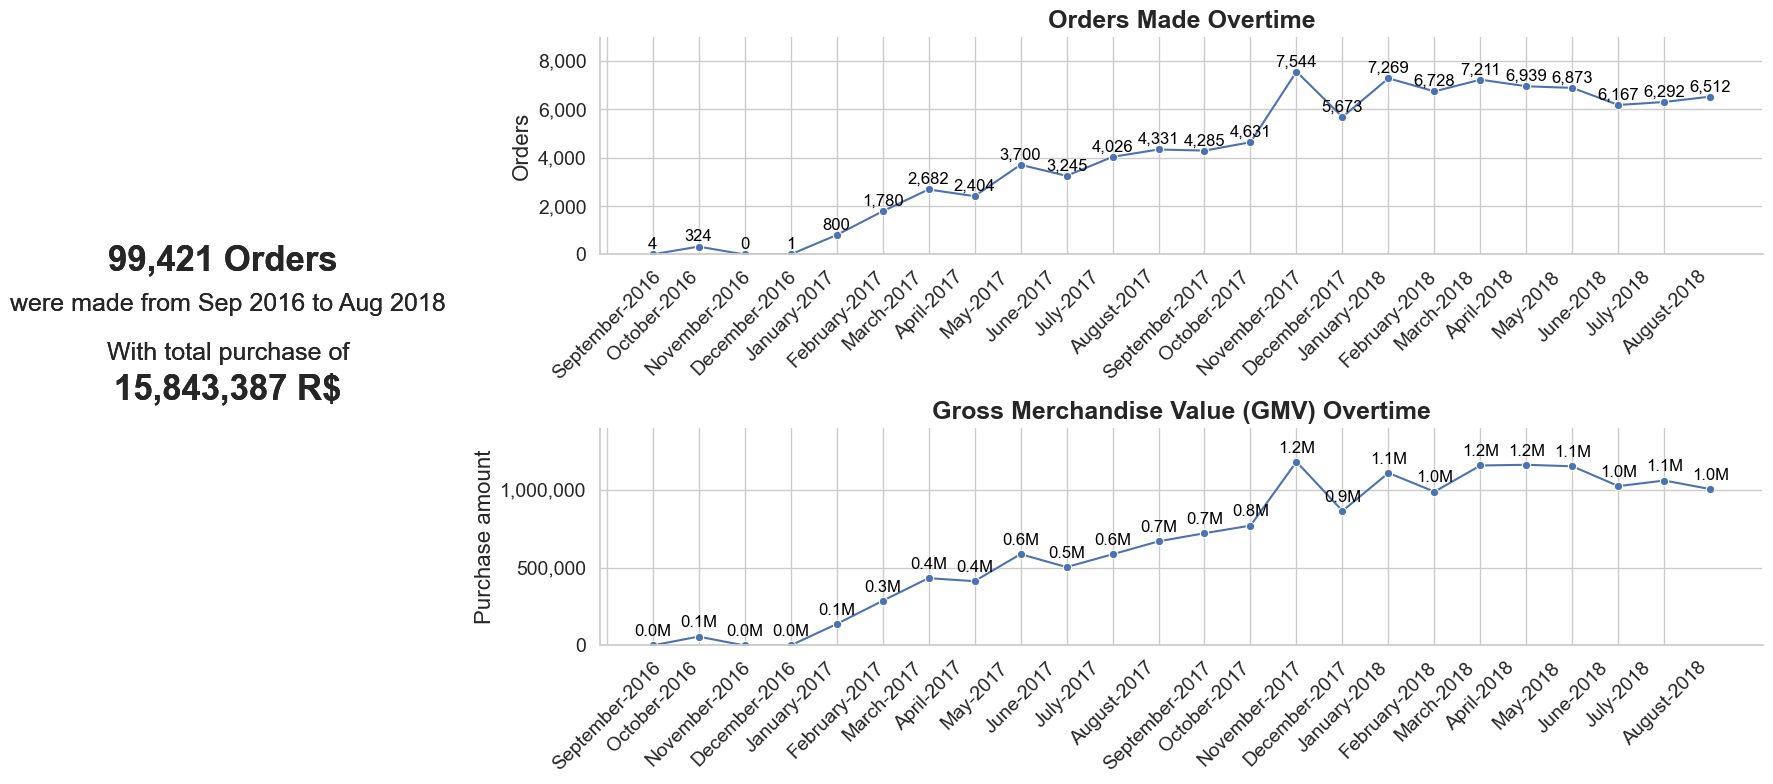

In [75]:
# Function to format y-axis labels with commas
def comma_formatter(x, pos):
    return f'{x:,.0f}'

# Function to create a line plot
def create_line_plot(ax, data, x_col, y_col, title, y_label, rotation=45, ylim=None, unit=None, text_offset=[0, 0]):
    sns.lineplot(x=x_col, y=y_col, data=data, marker='o', ax=ax)
    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.set_xlabel('', fontsize=14)
    ax.set_ylabel(y_label, fontsize=16)
    ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))
    ax.tick_params(axis='x', rotation=rotation, labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    if ylim is not None:
        ax.set_ylim(ylim)
    

    for i, (x, y) in enumerate(zip(data[x_col], data[y_col])):
        label_y = y
        label_format = '{:,.0f}'
        if unit == 'M':
            label_y /= 1_000_000  
            label_format = '{:.1f}M' 

        x_pos = i +text_offset[0]  # Adjust x position
        y_pos = y + text_offset[1]  # Adjust y position
        ax.text(x_pos, y_pos, label_format.format(label_y), color='black', ha='center', va='bottom')

    ax.set_xticks([tick - 1 for tick in range(len(data[x_col]))])
    ax.set_xticklabels(data[x_col])
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')

# Function to set text in the left panel
def set_text_panel(ax, pos, text, fontsize=18, fontweight=None, bg_color=None):
    ax.text(pos[0], pos[1], text, fontsize=fontsize, fontweight=fontweight, ha='center', va='center')
    ax.axis('off')
    if bg_color:
        ax.add_patch(mpatches.Rectangle((pos[0] - 0.1, pos[1] - 0.025), 0.2, 0.05, color=bg_color, transform=ax.transAxes, clip_on=False))
    ax.text(pos[0], pos[1], text, ha='center', va='center', fontweight=fontweight, fontsize=fontsize, transform=ax.transAxes)

# Plotting
fig = plt.figure(figsize=(18, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 5])  # 2 rows, 2 columns with width ratio

ax1 = plt.subplot(gs[0, 1])
create_line_plot(ax1, order_distribution, 
                 'Month_Year', 'cnt', 
                 'Orders Made Overtime', 'Orders',
                 text_offset=[0,100],
                 ylim=(0, 9000))

ax2 = plt.subplot(gs[1, 1])
create_line_plot(ax2, gmv_distribution, 
                 'Month_Year', 'gmv', 
                 'Gross Merchandise Value (GMV) Overtime', 'Purchase amount',
                 ylim=(0, 1400000),
                 text_offset=[0,40000],
                 unit='M')

ax_text = plt.subplot(gs[:, 0])
total_count_val = f'{order_distribution["cnt"].sum():,} Orders \n'
total_purchase_text = 'Total Purchase \n'
total_purchase_val = f'{gmv_distribution["gmv"].sum():,.0f} R$'
set_text_panel(ax_text, [0.5, 0.6], total_count_val, fontsize=25, fontweight='bold')
set_text_panel(ax_text, [0.5, 0.56], 'were made from Sep 2016 to Aug 2018')
set_text_panel(ax_text, [0.5, 0.48], 'With total purchase of')
set_text_panel(ax_text, [0.5, 0.42], total_purchase_val, fontsize=25, fontweight='bold')
plt.tight_layout()
plt.show()


Based on the analysis depicted in the provided figure, it is evident that there has been a consistent upward trend observed over the study period in both the Number of Orders and the Gross Merchandise Value (GMV). This trend indicates a progressive increase in business activity over time. Moreover, since the conclusion of 2017, the observed trend has stabilized, with minimal significant fluctuations noted in both metrics.

In light of these findings, the next step involves implementing seasonal analysis techniques to glean additional insights. By examining potential patterns in the evolution of GMV over time, we aim to uncover further actionable intelligence that may contribute to strategic decision-making processes.

C:\Users\hieu\AppData\Local\Temp\ipykernel_19956\3889064211.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gmv_distribution_seasonal_analysis['Month_Year'] = pd.to_datetime(gmv_distribution_seasonal_analysis['Month_Year'])


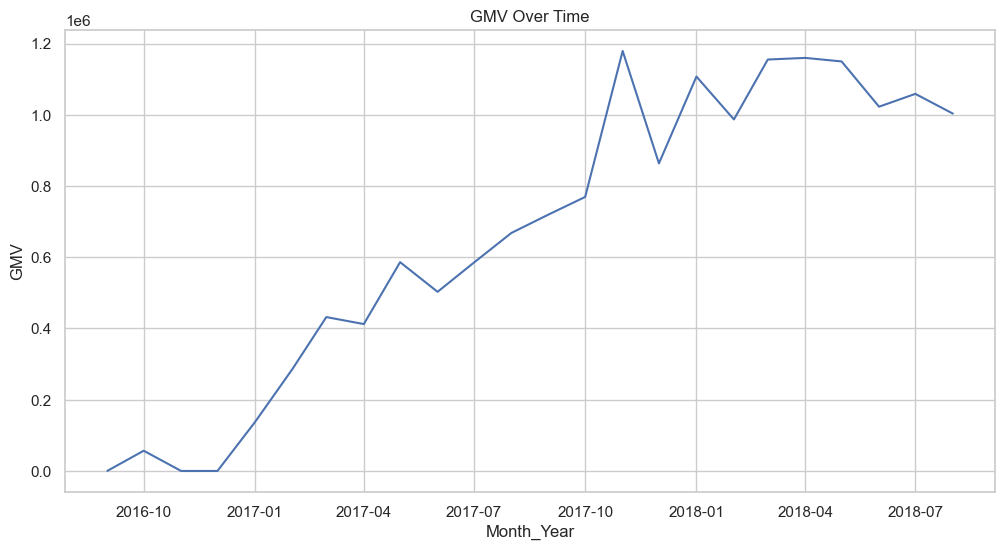

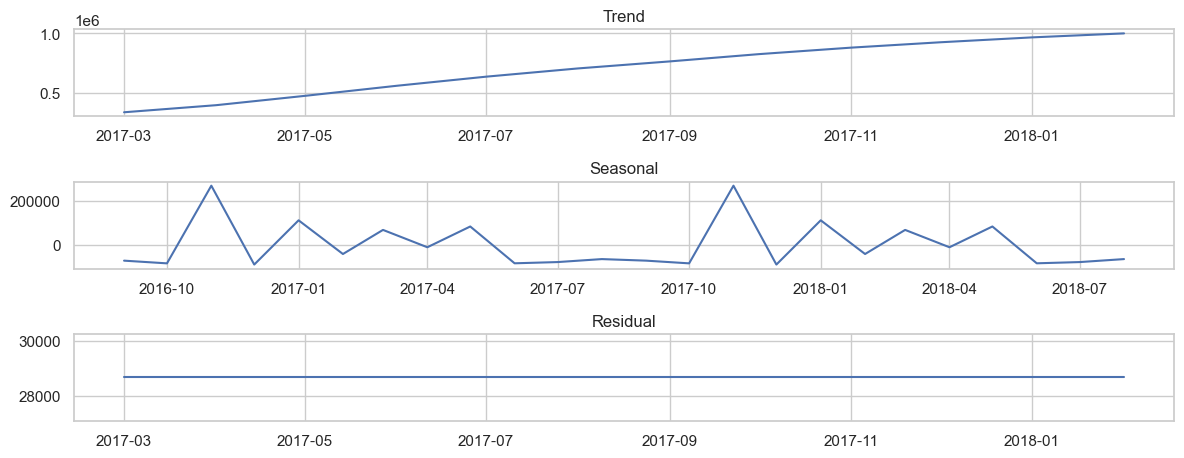

In [76]:
gmv_distribution_seasonal_analysis = gmv_distribution.copy()
gmv_distribution_seasonal_analysis['Month_Year'] = pd.to_datetime(gmv_distribution_seasonal_analysis['Month_Year'])

# Set the frequency of the DatetimeIndex explicitly to 'MS' (Month Start)
gmv_distribution_seasonal_analysis = gmv_distribution_seasonal_analysis.set_index('Month_Year').asfreq('MS')

# Plot GMV over time
plt.figure(figsize=(12, 6))
plt.plot(gmv_distribution_seasonal_analysis['gmv'])
plt.title('GMV Over Time')
plt.xlabel('Month_Year')
plt.ylabel('GMV')
plt.grid(True)
plt.show()

# Perform seasonal decomposition
decomposition = seasonal_decompose(gmv_distribution_seasonal_analysis['gmv'], model='additive')

# Plot seasonal components
plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.subplot(412)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')
plt.subplot(413)
plt.plot(decomposition.resid)
plt.title('Residual')
plt.tight_layout()
plt.show()


<font color="green">The seasonal decomposition of the GMV data reveals distinct patterns throughout the observed period. Notably, there is a pronounced spike in November, likely attributable to holiday sales and promotions. This is followed by a decrease in December as holiday shopping subsides, with a subsequent rebound in January. Further, fluctuations in GMV persist throughout the year, indicating ongoing variability influenced by factors such as economic status and e-commerce industry-specific trends.</font>


As the next action, which can be deprived from our findings, to maximize GMV, series of targeted strategies to capitalize on peak period and mitigate fluctuation as below for example:
1. **Optimize Marketing Efforts**: Develop targeted marketing campaigns and promotions to leverage the spike in GMV observed in November, ensuring visibility during peak shopping seasons and capitalizing on holiday-driven consumer spending.

2. **Enhance Product Offerings**: Introduce seasonal products or exclusive deals tailored to the observed trends, aligning inventory with anticipated demand fluctuations to meet customer needs and preferences.

3. **Maximize Customer Engagement**: Implement personalized marketing strategies and loyalty programs to drive repeat purchases and maintain engagement throughout the year, leveraging insights from seasonal patterns to deliver relevant and timely messaging.

4. **Diversify Sales Channels**: Explore opportunities to expand sales channels or partnerships to reach broader audiences and mitigate the impact of seasonal fluctuations, such as tapping into new markets or optimizing online sales platforms to capture off-peak demand.






### 6. Customer Analysis

In [77]:
customer_gmv = customer_order_items[['customer_id','gmv']].copy()
# Finding customer IDs that occur more than once
duplicate_ids = customer_gmv[customer_gmv.duplicated(subset=['customer_id'], keep=False)]['customer_id'].unique()

# Finding customer IDs that occur only once
unique_ids = customer_gmv[~customer_gmv.duplicated(subset=['customer_id'], keep=False)]['customer_id'].unique()

# Creating a DataFrame for type of customers and their occurrences
one_time_customers_count = len(unique_ids)
repeat_customers_count = len(duplicate_ids)

# Calculating total GMV for each type of customer
one_time_customer_gmv = customer_gmv[customer_gmv['customer_id'].isin(unique_ids)]['gmv'].sum()
repeat_customer_gmv = customer_gmv[customer_gmv['customer_id'].isin(duplicate_ids)]['gmv'].sum()

# Calculate average GMV
one_time_avg_gmv = one_time_customer_gmv / one_time_customers_count
repeat_avg_gmv = repeat_customer_gmv / repeat_customers_count

customer_type_df = pd.DataFrame({
    'Type of Customer': ['One Time Customer', 'Repeat Customer'],
    'Occurrence': [one_time_customers_count, repeat_customers_count],
    'Total GMV': [one_time_customer_gmv, repeat_customer_gmv],
    'Average GMV': [one_time_avg_gmv, repeat_avg_gmv]
})

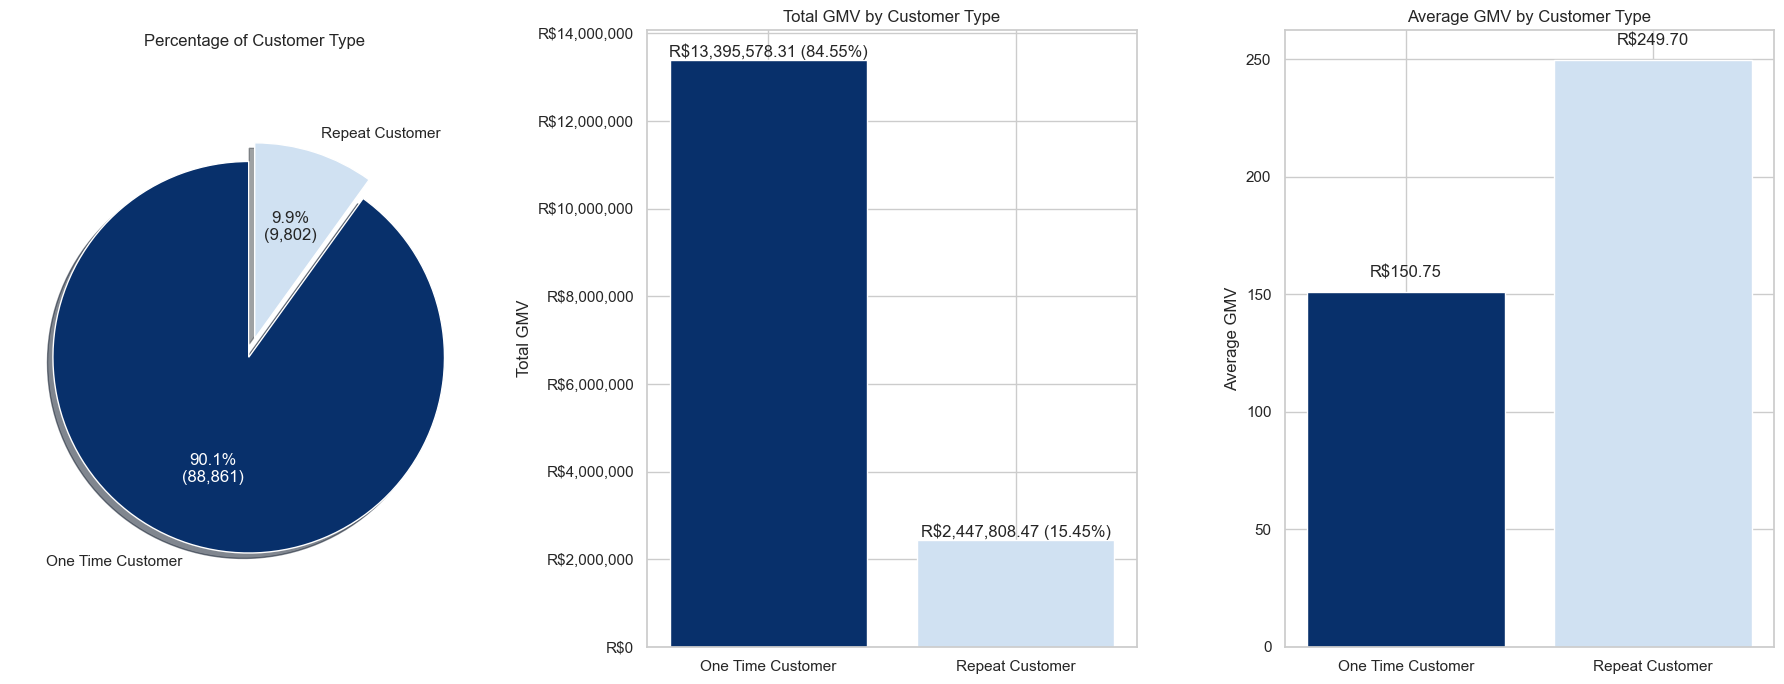

In [78]:
# Extracting data
customer_types = customer_type_df['Type of Customer']
occurrences = customer_type_df['Occurrence']
total_gmv = customer_type_df['Total GMV']
average_gmv = customer_type_df['Average GMV']  
# Creating color gradients
colors = plt.cm.Blues(np.linspace(0.2, 1, len(customer_types)))[::-1]

# Creating the pie chart
fig, axs = plt.subplots(1, 3, figsize=(18, 7))  # Update figsize to accommodate three plots

# Pie chart
explode = (0.1, 0.0)
def autopct_format(pct):
    absolute = int(pct/100.*np.sum(occurrences))
    return f'{pct:.1f}%\n({absolute:,})'

wedges, texts, autotexts = axs[0].pie(occurrences, autopct=autopct_format, explode=explode, labels=customer_types, shadow=True, colors=colors, startangle=90)
axs[0].set_title('Percentage of Customer Type', y=1.08)
for text, color in zip(autotexts, colors):
    if np.mean(color[:3]) < 0.5:  # Check if color is dark
        text.set_color('white')

# Bar chart
bar_plot = axs[1].bar(customer_types, total_gmv, color=colors)
axs[1].set_ylabel('Total GMV')
axs[1].set_title('Total GMV by Customer Type')

total_gmv_sum = sum(total_gmv)

for bar, value in zip(bar_plot, total_gmv):
    percentage = (value / total_gmv_sum) * 100
    axs[1].text(bar.get_x() + bar.get_width() / 2, value, f'R${value:,.2f} ({percentage:.2f}%)', ha='center', va='bottom')  # 'R$' represents the symbol for Brazilian Real

# Add comma separator to y-axis in bar chart
axs[1].get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda x, _: f'R${x:,.0f}'))

# Reduce size of bar chart by 40%
box = axs[1].get_position()
axs[1].set_position([box.x0, box.y0, box.width * 0.6, box.height * 0.6])

# Average GMV plot
axs[2].bar(customer_types, average_gmv, color=colors)
axs[2].set_ylabel('Average GMV')
axs[2].set_title('Average GMV by Customer Type')

# Add average GMV values on top of bars
for bar, value in zip(axs[2].patches, average_gmv):
    axs[2].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'R${value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


<font color="green">The repeat customer reveals a significant contrast in revenue contribution between repeat and one-time customers. Despite comprising only 9.9% of our customer base, repeat customers contribute a substantial 15.45% to our total Gross Merchandise Volume (GMV). Conversely, the majority of our clientele, accounting for 90.1%, are one-time customers, yet they contribute 84.55% of GMV.

Moreover, delving deeper into the data, we observe that repeat customers exhibit a higher average order value compared to one-time customers. On average, repeat customers spend $249.7 per transaction, while one-time customers spend $150.75.

These findings underscore the critical importance of prioritizing strategies aimed at retaining repeat customers. Not only do they contribute significantly to our revenue stream, but their propensity to spend more per transaction further emphasizes their economic value to the business. Therefore, retaining repeat customers is not only vital for fostering customer loyalty but also directly correlates with higher GMV. Repeat customers tend to demonstrate higher purchase frequency, larger average order values, and lower acquisition costs. By focusing on enhancing customer experiences, incentivizing repeat purchases, and building lasting relationships, we can ensure a stable revenue stream and drive sustainable growth while capitalizing on the higher lifetime value that repeat customers inherently offer.</font>

<div align="center">End of Analysis</div>
